# Adding measurements to `Schedule`s

Measurement is clearly a very important part of building a Pulse schedule -- this is how we get the results of our program execution! The powerful low-level control we are granted by Pulse gives us more freedom than `QuantumCircuit`s in specifying how the measurement should be done, enabling the user to explore readout error mitigation. This power of course comes with responsibility: we have to understand how measurement works, and accomodate certain hardware constraints.

On this page, we will explore in depth how to create measurements, using several different approaches of increasing complexity.

**Note: Pulse allows you to receive raw, kerneled, and disciminated readout data (whereas circuits will only return discriminated data). Documentation for these options can be found here-COMING SOON.**

### Quick reference for adding a backend-default measurement
There is a feature that allows you to add measurements as easily to `Schedule`s as to `QuantumCircuit`s, with just the qubits you want to measure (below, qubits 0 and 1) and your OpenPulse-enabled `backend`:

```
# Appending a measurement schedule to a Schedule, sched
from qiskit.pulse import measure
sched += measure([0, 1], backend) << sched.duration
```
The `backend` contains a default definition for measurement. Compare this to adding measurements to a `QuantumCircuit`, `qc`:
```
qc.measure(quantum_reg[0], classical_reg[0])
qc.measure(quantum_reg[1], classical_reg[1])
```

### Basic measurement pattern
Let's use the default measurement feature to inspect a measurement and learn what each pulse does.

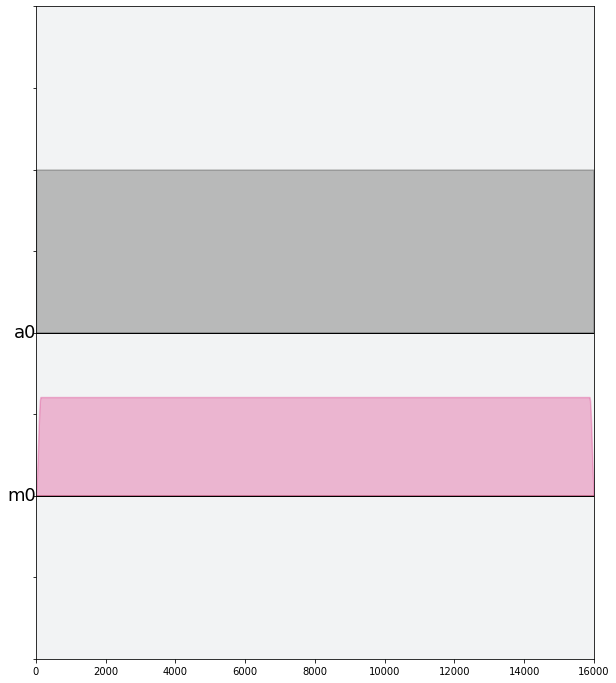

In [3]:
from qiskit import IBMQ
from qiskit.pulse import Schedule
from qiskit.scheduler.utils import measure_all

backend = IBMQ.load_account().backends(open_pulse=True)[0]

sched = Schedule(name="Measurement scheduling example")
sched += measure_all(backend)

sched.draw()

Each qubit has two channels related to readout. These are the readout transmit `MeasureChannel`s, and the readout receive `AcquireChannel`s. In superconducting qubit architectures, qubits are coupled to readout resonators. The coupling hybridizes the state between the qubit and the readout resonator. The `MeasureChannel` and `AcquireChannel`s label signal lines which connect to the readout resonator. When a stimulus pulse is sent to the The effect is that the signal reflected  

#### Additional options on `measure`

`qubit_mem_slots`
TODO explain how to do qubit mapping to mem slots

In [2]:
from qiskit.scheduler.utils import measure

sched = measure(qubits=[0], backend=backend, qubit_mem_slots={0: 1})

sched.instructions

((0,
  AcquireInstruction(Acquire(duration=16000, kernel=acq0, discriminator=None, name="None"), AcquireChannel(0), MemorySlot(1))),
 (0,
  PulseInstruction(SamplePulse(samples=array([0.00295201+0.j, 0.00597357+0.j, 0.00906536+0.j, ...,
         0.00906536+0.j, 0.00597357+0.j, 0.00295201+0.j]), name="M_m0_5e3c"), MeasureChannel(0))))

TODO other custom args for `measure`

`inst_map`

`meas_map`

### Measurement map `meas_map`

Due to control rack hardware constraints, some qubits may need to be acquired together. This can be the case for qubits whose readout channels are multiplexed. The OpenPulse backend will provide a `meas_map` to notify the user of this.

For instance, if we see this for a 5-qubit `backend`

```
backend.configuration().meas_map

Out: [[0, 1, 2, 3, 4]]
```

then we know that all the qubits on this device must be acquired together. On the other hand, if we see this

```
Out: [[0], [1], [2], [3, 4]]
```

this tells us that qubits 0, 1 and 2 can be acquired independently, but qubits 3 and 4 must be acquired together.

## From pulses

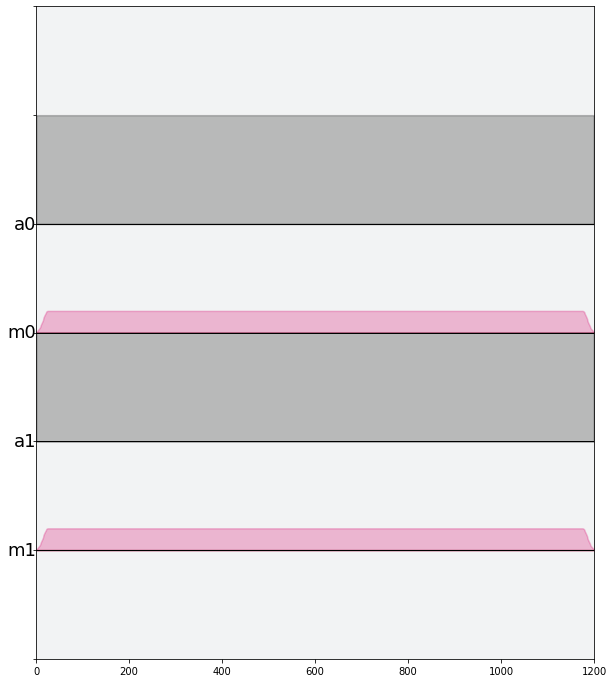

In [5]:
from qiskit.pulse import GaussianSquare, MeasureChannel, Acquire, AcquireChannel, MemorySlot

duration = 1200

measure_tx = GaussianSquare(duration=duration, amp=0.2, sigma=10, width=duration - 50)(MeasureChannel(0))
measure_tx += GaussianSquare(duration=duration, amp=0.2, sigma=10, width=duration - 50)(MeasureChannel(1))

acquire = Acquire(duration)
measure_rx = acquire(AcquireChannel(0), MemorySlot(0))
measure_rx += acquire(AcquireChannel(1), MemorySlot(1))

measure_sched = measure_tx + measure_rx

measure_sched.draw()